In [1]:
%pylab inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy.io import PostprocessedRasterSource, LocatedImage
from cartopy.io import srtm
from cartopy.io.srtm import SRTM3Source
import cartopy.feature as cfeature

from osgeo import gdal
from osgeo import gdal_array

import scipy.ndimage
import scipy.misc

from netCDF4 import Dataset


Populating the interactive namespace from numpy and matplotlib


In [2]:
base_projection     = ccrs.PlateCarree() 
global_extent     = [-180.0, 180.0, -90.0, 90.0]

strainrate_extent=[-180,180,-68,80]
strainrate = numpy.loadtxt("Resources/sec_invariant_strain_0.2.dat")
strainrate_data = strainrate.reshape(741,1800,3)  # I had to look at the data to work this out !
# strainrate_img  = strainrate_data[:,:,2] # Not actually used here !

In [ ]:
# Note: we need to manage the memory here since the Docker version can be limited 

etopo1       = gdal.Open("Resources/color_etopo1_ice_low.tif")
etopo_img    = etopo1.ReadAsArray().transpose(1,2,0)
del(etopo1)

globalrelief      = gdal.Open("Resources/HYP_50M_SR_W/HYP_50M_SR_W.tif")
globalrelief_img  = globalrelief.ReadAsArray().transpose(1,2,0)
del(globalrelief)

globalbathym      = gdal.Open("Resources/OB_50M/OB_50M.tif")
globalbathym_img  = globalbathym.ReadAsArray().transpose(1,2,0)
del(globalbathym)

global_shrelief = gdal.Open("Resources/etopo1_grayscale_hillshade.tif")
global_shrelief_img = global_shrelief.ReadAsArray()[::2,::2] / 256.0
del(global_shrelief)

# Height field only ... 
etopoH = gdal.Open("Resources/ETOPO1_Ice_c_geotiff.tif") 
etopoH_img = etopoH.ReadAsArray()[::2,::2]
del(etopoH)

In [8]:
etopoH_img2 = (etopoH_img - etopoH_img.min()) / (etopoH_img.max() - etopoH_img.min())

MemoryError: 

In [5]:
print etopo_img.shape
print globalrelief_img.shape
print globalbathym_img.shape
print etopoH_img.shape
print global_shrelief_img.shape

(2700, 5400, 3)
(5400, 10800, 3)
(5400, 10800, 3)
(5400, 10800)
(5401, 10801)


In [6]:
blended_img = np.empty_like(globalrelief_img)
blended_img[...,0] = np.where( etopoH_img < 0.0, globalbathym_img[...,0], globalrelief_img[...,0] )
blended_img[...,1] = np.where( etopoH_img < 0.0, globalbathym_img[...,1], globalrelief_img[...,1] )
blended_img[...,2] = np.where( etopoH_img < 0.0, globalbathym_img[...,2], globalrelief_img[...,2] )

In [3]:
# img_heights  = etopo_img.reshape(-1)

base_projection = ccrs.PlateCarree()
global_extent = [ -180, 180, -90, 90 ]

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor="blue", facecolor="blue")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

graticules_5 = cfeature.NaturalEarthFeature('physical', 'graticules_5', '10m',
                           edgecolor="black", facecolor=None)


MemoryError: 

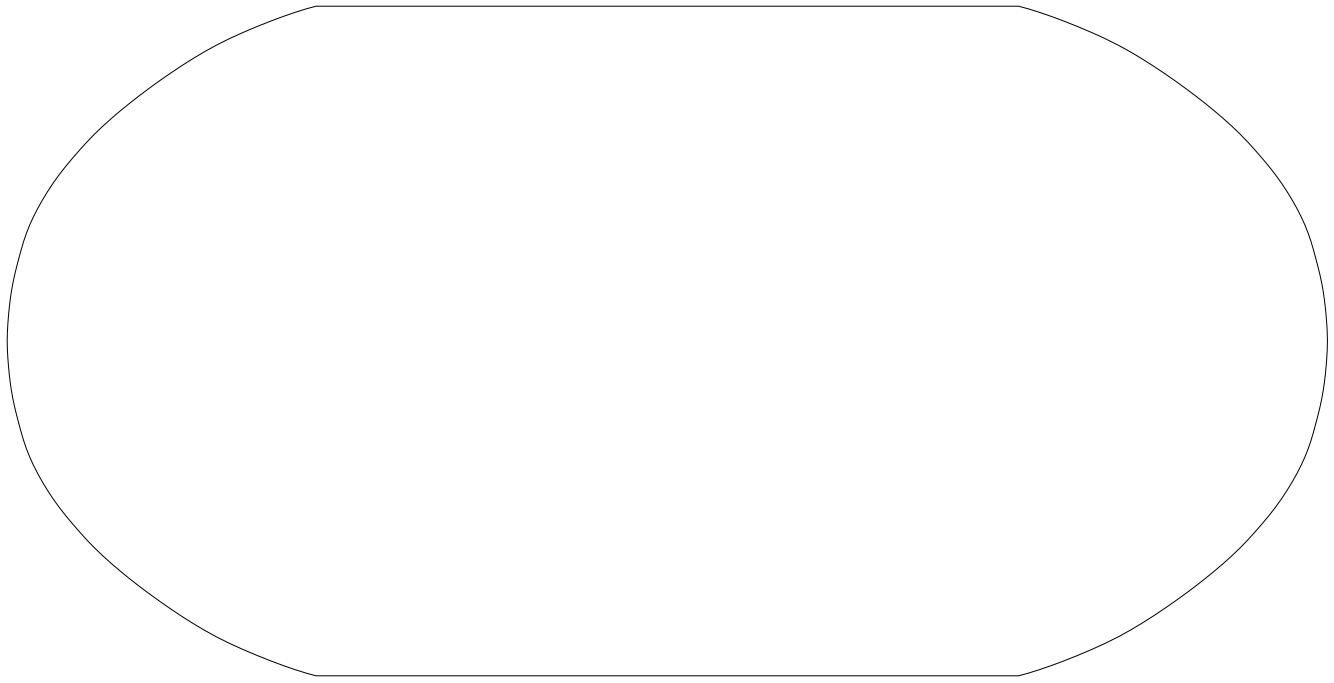

In [12]:

# rootgrp = Dataset("Resources/velocity_EU.nc", "r", format="NETCDF4")
rootgrp = Dataset("Resources/velocity_EU.nc", "r", format="NETCDF4")

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::5]
lats = latv[::5]
llX, llY = np.meshgrid(lons,lats)

#llX = llX.reshape(-1)
#llY = llY.reshape(-1)

Veast = (np.array(ve[::5,::5]).T)
Vnorth = (np.array(vn[::5,::5]).T)

Vorientation = np.arctan2(Vnorth,Veast)


#projection = ccrs.Orthographic(central_longitude=-150.0, central_latitude=60.0, globe=None)
projection = ccrs.Orthographic(central_longitude=120.0, central_latitude=5.0, globe=None)
projection = ccrs.PlateCarree()
# projection = ccrs.Mollweide(central_longitude=120)
projection = ccrs.Robinson(central_longitude=120)

fig = plt.figure(figsize=(24, 12), facecolor="none")

ax = plt.axes(projection=projection)


# ax.imshow(etopoH_img, transform=ccrs.PlateCarree(), origin="upper", 
#            alpha=1.0, extent=global_extent, interpolation="spline16", cmap=cm.gray_r, zorder=0)


ax.imshow(etopoH_img, transform=ccrs.PlateCarree(), origin="upper", 
           alpha=1.0, extent=global_extent, interpolation="nearest", cmap=cm.gray_r, zorder=0)




# global_shrelief_img

# mappable2 = ax.contourf(strainrate_data[:,:,0], strainrate_data[:2,:2,1], strainrate_data[:2,:2,2], 
#          levels=[10, 20, 50, 100, 200, 500], linestyle=None, vmin=1.0, vmax=200,
#          transform=base_projection,  cmap=cm.OrRd_r, alpha=0.75, 
#          extent=strainrate_extent, extend="max", zorder=12)


plt.colorbar(mappable=mappable2)




mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")
#ax.streamplot(lons, lats, Veast, Vnorth, transform=ccrs.PlateCarree())


ax.add_feature(coastline, linewidth=1.0,  edgecolor="#000000", zorder=2, alpha=0.75)
# ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
# ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=3, alpha=0.25)
# ax.add_feature(graticules_5, linewidth=0.25, edgecolor="black", linestyle=":", zorder=1, alpha=0.75)



In [ ]:
#fig.savefig("PlateMotionsPlateCarree.png", dpi=300) 
fig.savefig("PlateMotionsRobinson.png", dpi=500)